In [1]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import normalize

In [26]:
def simul_gamm(K, alpha, M=100000):
    """
    Calculate γ by Monte Carlo sampling
    """
    X = np.random.dirichlet(np.ones(K)*alpha, M)
    kmeans = KMeans(n_clusters=K, n_init=1, max_iter=5000).fit(X)
    centers = kmeans.cluster_centers_
    
    cent = 1./K * np.ones(K)
    γ = np.sqrt(K*(K-1.))/np.linalg.norm(centers - cent, axis=1).sum()
    return γ

def get_theta(cent, centers, γ):
    thetas = np.array([cent + γ*(centers[x,:] - cent) for x in range(centers.shape[0])])
    thetas[thetas<0] = 0
#     thetas = normalize(thetas, 'l1')
    
    return thetas

def cov_dir(K, α):
    S = 1/(K * (K*α + 1)) * (np.eye(K) - 1/K * np.ones((K, K)))
    return S

def search_alpha(Σ, cent, D_centers):
    α_list = np.arange(0.05,1.01,0.01)
    α_dict = {}
    for α in α_list:
        S = cov_dir(K, α)
        γ = simul_gamm(K, α)
        θ = get_theta(cent, D_centers, γ)
        θbar = θ.mean(axis=0)
        cov_mu = (θ.T @ S) @ θ
        estimate_Σ = np.diag(θbar) - np.diag(θbar * θbar) + cov_mu - np.diag(np.diag(cov_mu)) 
#         estimate_Σ = np.diag(θbar) - θbar.reshape(L, 1) @ θbar.reshape(1, L)
        α_dict.update({α: np.linalg.norm(estimate_Σ - Σ)})
    αhat = min(α_dict, key=α_dict.get)
    return αhat     

def admix_prop(X, θ):
    N, L  = X.shape
    K = θ.shape[0]
    θK = θ[K-1, :].reshape(1, L)
    θnoK = (θ - θK)[:(K-1), :]
    Q = np.zeros((N, K))
    Q[:, :(K-1)] = (X - θK) @ np.linalg.pinv(θnoK)
    Q[:, (K-1)] = np.ones(N) - np.sum(Q[:, :(K-1)], axis=1)
    Q[Q < 0] = 0
    Q = normalize(Q, norm='l1', axis=1)
    return Q

In [27]:
def VLAD(X, K, α=None):
    x_mean = X.mean(axis=0)
    x_cov = np.dot((X-x_mean).T, X-x_mean)/X.shape[0]
    cent = X.mean(axis=0)
    u, s, v = np.linalg.svd(X-cent, full_matrices=False)
    s = s[:K]
    X_svd = u[:,:K]
    v_back = s.reshape(-1,1)*v[:K]
    
    init_centers = KMeans(n_clusters=K, max_iter=10).fit(X-cent).cluster_centers_
    v_to_svd = v[:K].T * 1./s
    init_centers = np.dot(init_centers, v_to_svd)
    u_centers = KMeans(n_clusters=K, init=init_centers, n_init=1).fit(X_svd).cluster_centers_
    
    D_centers = np.dot(u_centers, v_back) + cent
    if α==None:
        α = search_alpha(x_cov, cent, D_centers)
    γ = simul_gamm(K, α)
    θ = get_theta(cent, D_centers, γ)
    return θ

In [77]:
# %run Simulate_data.ipynb

In [8]:
# N = 200
# L = 200
# Q0 = [0.5, 0.5, 0.5]
# K = 3

In [9]:
# X, q_true = simulate_data(N, L, Q0)

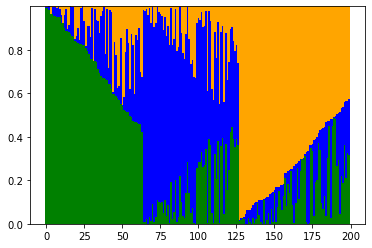

In [10]:
# colors = ['green','blue','orange','red', 'yellow']
# sorted_ind = reorder(q_true)
# ax1 = bar_plot(q_true, sorted_ind, colors)

In [36]:
# K = 3
# θ = VLAD(X, K,α=0.5)

0.5


In [37]:
# q_pred = admix_prop(X, θ)

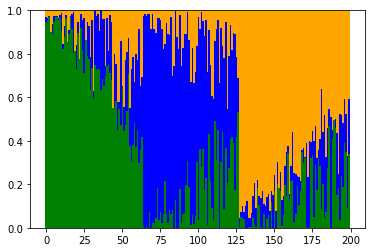

In [40]:
# ax2 = bar_plot(q_pred, sorted_ind, colors, switch_label=[1, 0, 2])

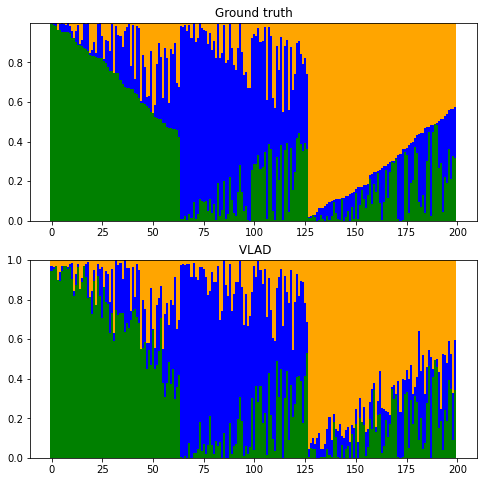

In [83]:
# q_pred_sorted = q_pred[:,[1,0,2]]
# qs=[q_true, q_pred_sorted]
# several_bar_plot(qs, sorted_ind, colors, figsize=(8,8), titles=['Ground truth',' VLAD'])